####BIRD DETECTOR

In [66]:
#Libraries required
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

In [67]:
#Helper function used to read images and bboxes from the dataset and change data type

def read_image_tfds_with_original_bboxes(data):
  image = data['image']
  bbox = data['bbox']

  shape = tf.shape(image)
  factor_x = tf.cast(shape[1], tf.float32)
  factor_y = tf.cast(shape[0], tf.float32)
#denormalization
  bbox_list = [bbox[1] * factor_x,
               bbox[0] * factor_y,
               bbox[3] * factor_x,
               bbox[2] * factor_y]
  return image, bbox_list

In [68]:
#method to convert the images and bboxes into numpy arrays
def dataset_to_numpy_util(dataset, batch_size=0, N=0):
      
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

In [87]:
#method to draw the bounding boxes for visualization
def draw_bounding_boxes_on_image_array(image, boxes, color = [], thickness = 5):
  boxes_shape = boxes.shape
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    cv2.rectangle(image, (int(boxes[i][0]), int(boxes[i][1])), (int(boxes[i][2]), int(boxes[i][3])), color, thickness)
  return image

In [70]:
from google.colab.patches import cv2_imshow
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_birds_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color = (255, 0, 0))
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
        
        
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=6033,
    splits={
        'test': 3033,
        'train': 3000,
    },
    supervised_keys=('ima

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


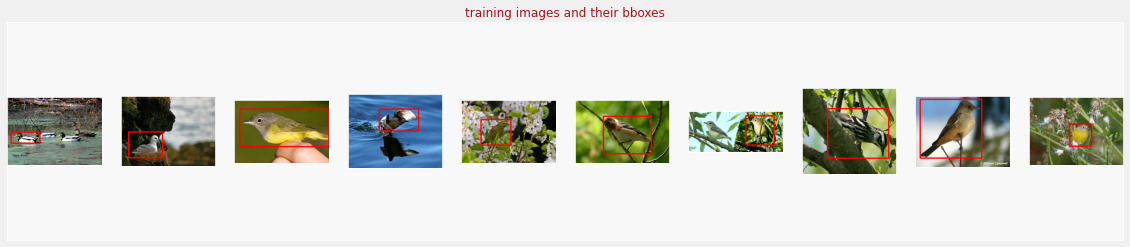

In [71]:
dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir='/content', download=True)
print(info)
visualization_training_dataset = dataset.map(read_image_tfds_with_original_bboxes, 
                                                 num_parallel_calls=16)

(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_birds_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


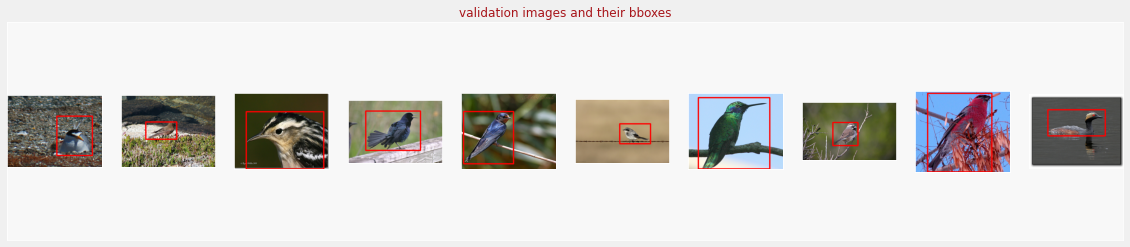

In [72]:
dataset = tfds.load("caltech_birds2010", split="test", data_dir='/content', download=True)
visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bboxes, num_parallel_calls=16)

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_birds_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

In [73]:
#method to normalize the dataset before it is fed to the model for training
def read_image_tfds(image, bbox):  
  image = tf.cast(image, tf.float32)
  shape = tf.shape(image)

  factor_x = tf.cast(shape[1], tf.float32)
  factor_y = tf.cast(shape[0], tf.float32)

  image = tf.image.resize(image, (224, 224, ))

  image = image/127.5
  image -= 1

  bbox_list = [bbox[0] / factor_x,
               bbox[1] / factor_y,
               bbox[2] / factor_x,
               bbox[3] / factor_y]
  
  return image, bbox_list

In [74]:
def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

In [75]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

###MODEL

In [76]:
def feature_extractor(inputs):
  mobilenet_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3),
                                                      include_top = False,
                                                      weights = 'imagenet')
  feature_extractor = mobilenet_model(inputs)
  return feature_extractor

In [77]:
def dense_layers(features):
  x = tf.keras.layers.GlobalAveragePooling2D()(features)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
  x = tf.keras.layers.Dense(512, activation = 'relu')(x)
  return x

In [78]:
def bounding_box_regressor(x):
  bounding_box_regression_output = tf.keras.layers.Dense(4, activation = 'linear', name = 'bounding_box')(x)
  return bounding_box_regression_output

In [79]:
def final_model(inputs):
  feature_cnn = feature_extractor(inputs)
  last_dense_layer = dense_layers(feature_cnn)
  bounding_box_output = bounding_box_regressor(last_dense_layer)

  model = tf.keras.models.Model(inputs = inputs, outputs = bounding_box_output)

  return model

In [80]:
def define_and_compile_model():
  inputs = tf.keras.layers.Input(shape = (224, 224, 3))
  model = final_model(inputs)

  model.compile(loss = 'mse',
                optimizer = tf.keras.optimizers.SGD(momentum=0.9),
                metrics = 'acc')
  
  return model
  

In [81]:
model = define_and_compile_model()
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
bounding_box (Dense)         (None, 4)                 2052

In [82]:
import math

EPOCHS = 50
BATCH_SIZE = 32
length_of_training_dataset = len(visualization_training_dataset)
length_of_validation_dataset = len(visualization_validation_dataset)
steps_per_epoch = math.ceil(length_of_training_dataset / BATCH_SIZE)
validation_steps = math.ceil(length_of_validation_dataset / BATCH_SIZE)

###TRAINING

In [83]:
history = model.fit(x=training_dataset, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    epochs=EPOCHS)

Epoch 1/50
29/94 [========>.....................] - ETA: 28s - loss: 0.1726 - acc: 0.4628

KeyboardInterrupt: ignored

###TO SAVE THE MODEL

In [64]:
model.save("birds.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [65]:
from google.colab import files

files.download("birds.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

1/1 [==============================] - 0s 378ms/step - loss: 10069311488.0000 - acc: 0.7188
Loss:  [10069311488.0, 0.71875]


In [84]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

In [93]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Number of predictions where iou > threshold(0.5): 249
Number of predictions where iou < threshold(0.5): 251
